In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu

2025-04-14 10:48:11.086541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744627691.328924      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744627691.397416      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
plt.rcParams['font.size'] = 12
sns.set_style("dark")

In [4]:
flickr8k_image_path = '/kaggle/input/flickr8k/Images'
flickr8k_data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
flickr8k_data['dataset'] = 'flickr8k'

In [5]:
print(flickr8k_data.isnull().sum())
flickr8k_data = flickr8k_data.dropna(subset=['caption'])

image      0
caption    0
dataset    0
dtype: int64


In [6]:
flickr8k_data['image_path'] = flickr8k_data['image'].apply(lambda x: os.path.join(flickr8k_image_path, x))
flickr8k_data['image_exists'] = flickr8k_data['image_path'].apply(os.path.exists)
flickr8k_data = flickr8k_data[flickr8k_data['image_exists']].drop(columns=['image_exists'])

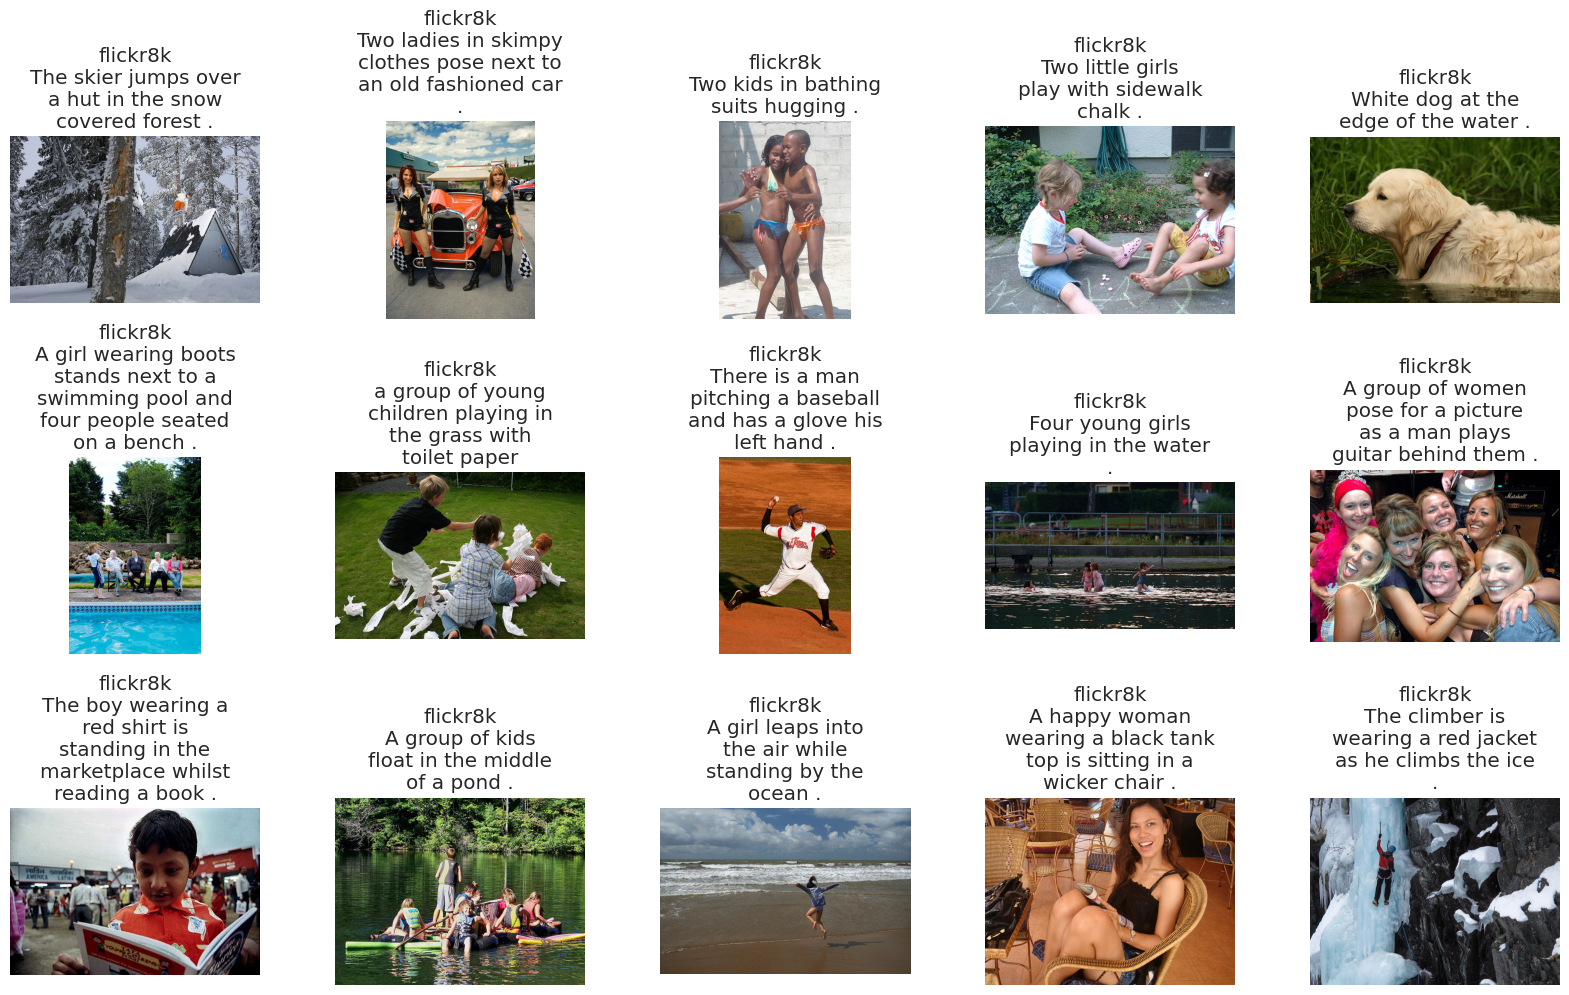

In [7]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    for i in range(min(15, len(temp_df))):
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = Image.open(temp_df.image_path[i]).convert('RGB')
        plt.imshow(image)
        plt.title(f"{temp_df.dataset[i]}\n" + "\n".join(wrap(str(temp_df.caption[i]), 20)))
        plt.axis("off")
    plt.show()

display_images(flickr8k_data.sample(15))

In [8]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: str(x).lower())
    data['caption'] = data['caption'].str.replace("[^A-Za-z]", "", regex=True)
    data['caption'] = data['caption'].str.replace("\s+", " ", regex=True)
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    return data

flickr8k_data = text_preprocessing(flickr8k_data)

In [9]:
images = flickr8k_data[['image', 'dataset']].drop_duplicates().values.tolist()
np.random.shuffle(images)

split_index = round(0.85 * len(images))
train_images = [img[0] for img in images[:split_index]]
val_images = [img[0] for img in images[split_index:]]

train = flickr8k_data[flickr8k_data['image'].isin(train_images)].reset_index(drop=True)
test = flickr8k_data[flickr8k_data['image'].isin(val_images)].reset_index(drop=True)

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_file = self.df['image_path'][idx]
        caption = self.df['caption'][idx]
        image = Image.open(image_file).convert('RGB')
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding=True)
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        return inputs

In [11]:
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0: return None
    keys = batch[0].keys()
    batched = {key: [] for key in keys}
    for item in batch:
        for key in keys:
            batched[key].append(item[key])
    batched['input_ids'] = torch.nn.utils.rnn.pad_sequence(batched['input_ids'], batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    batched['attention_mask'] = torch.nn.utils.rnn.pad_sequence(batched['attention_mask'], batch_first=True, padding_value=0)
    batched['pixel_values'] = torch.stack(batched['pixel_values'])
    return batched

In [12]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [13]:
train_dataset = FlickrDataset(train, processor)
test_dataset = FlickrDataset(test, processor)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

In [14]:
train_dataset = FlickrDataset(train, processor)
test_dataset = FlickrDataset(test, processor)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 2
best_val_loss = float('inf')
patience = 1
patience_counter = 0

model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training {epoch+1}/{num_epochs}", leave=False):
        if batch is None: continue
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validating", leave=False):
            if batch is None: continue
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            val_loss += outputs.loss.item()
    avg_val_loss = val_loss / len(test_dataloader)

    status_msg = f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}"

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        model.save_pretrained("best_blip_caption_model")
        processor.save_pretrained("best_blip_caption_model")
        status_msg += " ✅ Model saved."
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(status_msg + " ⛔ Early stopping.")
            break
    print(status_msg)
    model.train()


Epoch 1/2


Epoch 1/2 - Train Loss: 2.5597 - Val Loss: 2.2686 ✅ Model saved.

Epoch 2/2


Epoch 2/2 - Train Loss: 1.8804 - Val Loss: 2.1271 ✅ Model saved.


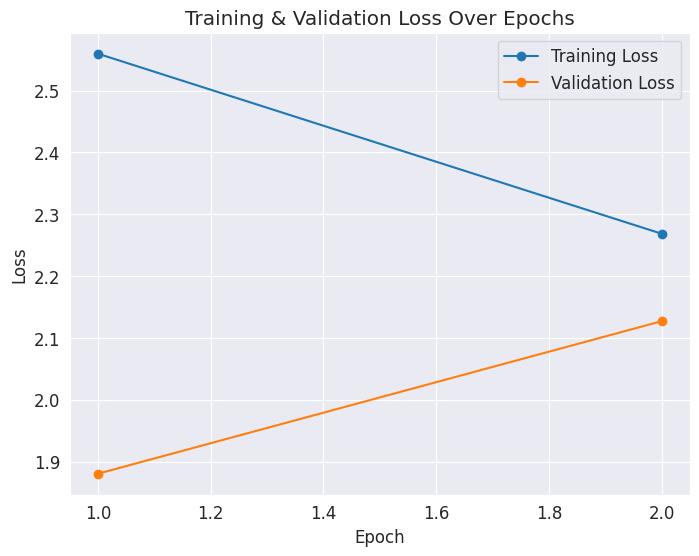

In [28]:
import matplotlib.pyplot as plt

# Replace these lists with your real loss values
train_losses = [2.5597, 2.2686]  # Example: [epoch1_train_loss, epoch2_train_loss, ...]
val_losses = [1.8804, 2.1271]    # Example: [epoch1_val_loss, epoch2_val_loss, ...]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def predict_caption(model, processor, image_path, max_length=50):
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt").to(device)
        generated_ids = model.generate(pixel_values=inputs["pixel_values"], max_length=max_length)
        return processor.decode(generated_ids[0], skip_special_tokens=True)

samples = test.sample(20).reset_index(drop=True)
bleu_scores = []
for index, row in samples.iterrows():
    generated = predict_caption(model, processor, row['image_path'])
    samples.loc[index, 'generated_caption'] = generated
    bleu = sentence_bleu([row['caption'].split()], generated.split())
    bleu_scores.append(bleu)

print(f"Average BLEU Score: {np.mean(bleu_scores):.4f}")

Average BLEU Score: 0.0000


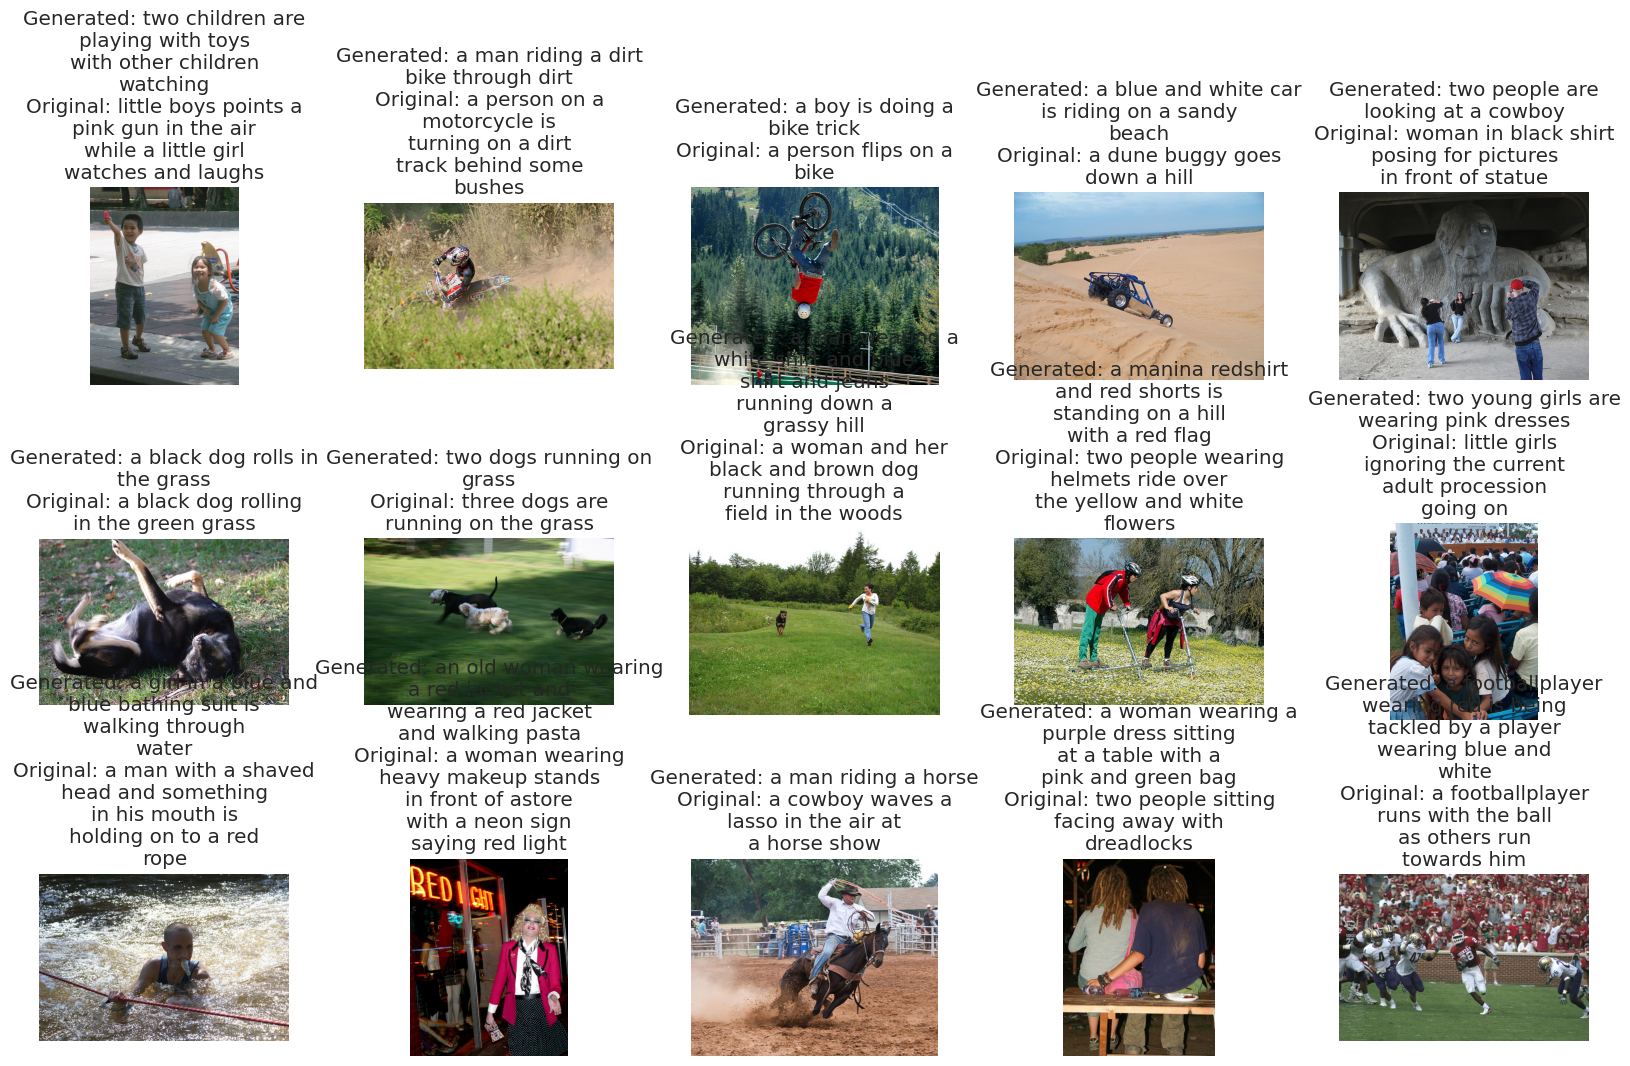

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
from textwrap import wrap
import wordninja

# Preprocess captions to fix missing spaces
def fix_caption_spaces(df):
    df['generated_caption'] = df['generated_caption'].apply(lambda x: ' '.join(wordninja.split(str(x))))
    df['caption'] = df['caption'].apply(lambda x: ' '.join(wordninja.split(str(x))))
    return df

# Display Function (No Save, Only Show)
def display_shuffled_predicted_images(temp_df):
    temp_df = fix_caption_spaces(temp_df)  # Fix captions before plotting
    
    # Shuffle the dataframe
    temp_df = temp_df.sample(frac=1).reset_index(drop=True)

    plt.figure(figsize=(20, 20))
    for i in range(min(15, len(temp_df))):
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        image = Image.open(temp_df.image_path[i]).convert('RGB')
        plt.imshow(image)

        generated_wrapped = "\n".join(wrap(str(temp_df.generated_caption[i]), 20, break_long_words=False))
        original_wrapped = "\n".join(wrap(str(temp_df.caption[i]), 20, break_long_words=False))

        plt.title(f"Generated: {generated_wrapped}\nOriginal: {original_wrapped}")
        plt.axis("off")

    plt.show()

# Usage
display_shuffled_predicted_images(samples)

In [ ]:
import shutil

# Replace 'output_folder_name' with your actual folder name
folder_to_zip = '/kaggle/working/best_blip_caption_model'
output_zip = '/kaggle/working/best_blip_caption_model.zip'

# Create zip
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=folder_to_zip)

print(f"✅ Zipped folder saved to: {output_zip}")
